In [1]:
%matplotlib widget

#### Inflation vs. Brent
The below reproduces the behaviour of Brent and Inflation.
It also looks at the inflation vs. 5y5y expectations and how that correlates with the price of oil, like the brief research blog: https://fredblog.stlouisfed.org/2020/04/oil-prices-and-expected-inflation/

In [2]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from fredapi import Fred as FredApi

fred = FredApi(api_key='0dfcbb403eea7fee006f01e935be9216')

cpiausl = fred.get_series_latest_release('CPIAUCSL')
brent_daily = fred.get_series_latest_release('DCOILBRENTEU')
be5y5y_daily = fred.get_series_latest_release('T5YIFR')

In [3]:
# verify what the latest number available is
cpiausl.tail()

2021-11-01    278.524
2021-12-01    280.126
2022-01-01    281.933
2022-02-01    284.182
2022-03-01    287.708
dtype: float64

In [4]:
# the brent series is daily - so i resample monthly and take an average. Same for the 5y5y inflation breakeven to be used later on
brent = brent_daily.resample('M').mean()
be5y5y = be5y5y_daily.resample('M').mean()

In [5]:
# see where the Brent series stops first (only month now is relevant)
brent.tail()

2021-12-31     74.170476
2022-01-31     86.505238
2022-02-28     97.129000
2022-03-31    117.245217
2022-04-30    105.024545
Freq: M, dtype: float64

In [6]:
# it's useful to make sure that Python understands the frequency being "monthly" even though data
# don't necessarily show this. Resampling is a way around it and selecting "last" as the value of the
# resampling (there is only 1 value)
# compare the indices of the prior version of "brent" to this version of "brent" (note reassignment)
brent = brent.resample('M').last()
brent_yoy = brent.pct_change(periods=12) * 100.
brent.tail()

2021-12-31     74.170476
2022-01-31     86.505238
2022-02-28     97.129000
2022-03-31    117.245217
2022-04-30    105.024545
Freq: M, dtype: float64

In [7]:
# now extend the brent timeseries with a constant one
new_index = pd.date_range(start=brent.index[-1], freq='M', periods=12)
brent_projection = pd.Series(data=brent.iloc[-1], index=new_index)
# concatenate the two brent timeseries one to the other
brent_extended = pd.concat([brent, brent_projection.iloc[1:]])
brent_extended.tail(24)

2021-04-30     64.806500
2021-05-31     68.534211
2021-06-30     73.164091
2021-07-31     75.165909
2021-08-31     70.747143
2021-09-30     74.488636
2021-10-31     83.538095
2021-11-30     81.050000
2021-12-31     74.170476
2022-01-31     86.505238
2022-02-28     97.129000
2022-03-31    117.245217
2022-04-30    105.024545
2022-05-31    105.024545
2022-06-30    105.024545
2022-07-31    105.024545
2022-08-31    105.024545
2022-09-30    105.024545
2022-10-31    105.024545
2022-11-30    105.024545
2022-12-31    105.024545
2023-01-31    105.024545
2023-02-28    105.024545
2023-03-31    105.024545
Freq: M, dtype: float64

In [8]:
# make a yoy variation as a % change for the CPI
# note the change in index as well here... same as above
cpiausl = cpiausl.resample('M').last()
cpiausl_yoy = cpiausl.pct_change(periods=12) * 100.
cpiausl_yoy.tail()

2021-11-30    6.828372
2021-12-31    7.096542
2022-01-31    7.525934
2022-02-28    7.912024
2022-03-31    8.557586
Freq: M, dtype: float64

In [9]:
# make a yoy variation as a % change for the extended brent projection
# and then check the numbers vs. what you have above to see if it makes
# sense (good practice!)
brent_extended_yoy = brent_extended.pct_change(periods=12) * 100.
brent_extended_yoy.tail(12)

2022-04-30    62.058660
2022-05-31    53.243971
2022-06-30    43.546573
2022-07-31    39.723642
2022-08-31    48.450582
2022-09-30    40.994050
2022-10-31    25.720541
2022-11-30    29.579945
2022-12-31    41.598856
2023-01-31    21.408307
2023-02-28     8.128927
2023-03-31   -10.423173
Freq: M, dtype: float64

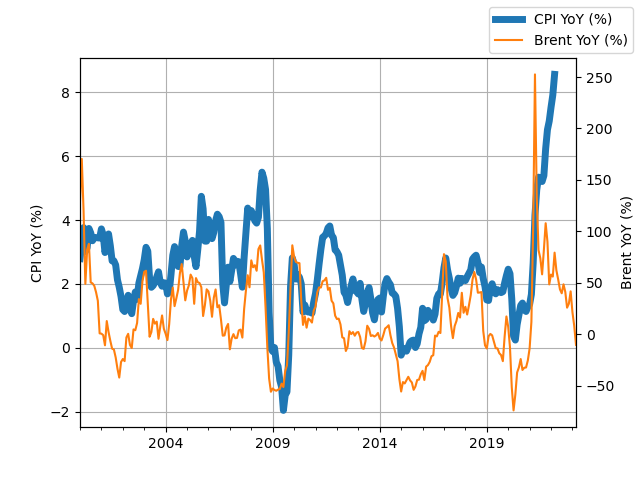

In [10]:
# plot and set labels of the figure
START_YEAR = '2000'
fig, ax = plt.subplots()
cpiausl_yoy.loc[START_YEAR:].plot(ax=ax, linewidth=5);
ax2 = brent_extended_yoy.loc[START_YEAR:].plot(secondary_y=True, ax=ax);
ax.grid(True);
ax.set_ylabel('CPI YoY (%)');
ax2.set_ylabel('Brent YoY (%)');
ax.figure.legend(['CPI YoY (%)','Brent YoY (%)']);

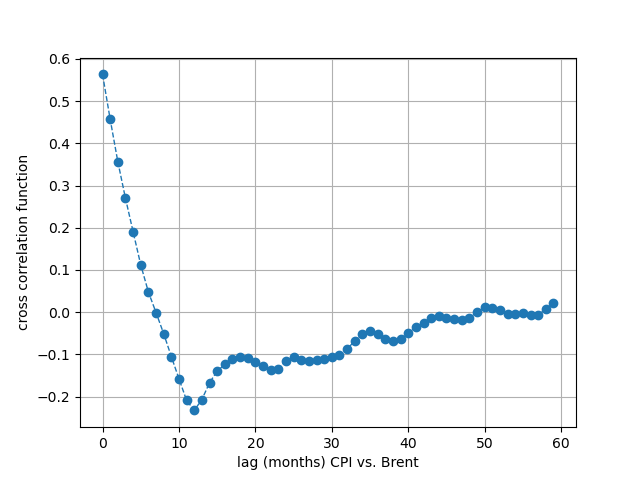

In [11]:
# now let's try to cross-correlate these 2 indicators to see the lags at which there is some correlation 
# and how big that is. To do so, we only look at the real data available, not the extended brent series.
import statsmodels.tsa.stattools as smtsast
common_dates = brent_yoy.loc[~brent_yoy.isna()].index.intersection(cpiausl_yoy.index)
cc = smtsast.ccf(brent_yoy.loc[common_dates], cpiausl_yoy.loc[common_dates])
cross_correl_function = pd.Series(cc[:60])
fig, ax = plt.subplots()
cross_correl_function.plot(ax=ax, linewidth=1, style='o--');
ax.grid(True);
ax.set_xlabel('lag (months) CPI vs. Brent');
ax.set_ylabel('cross correlation function');

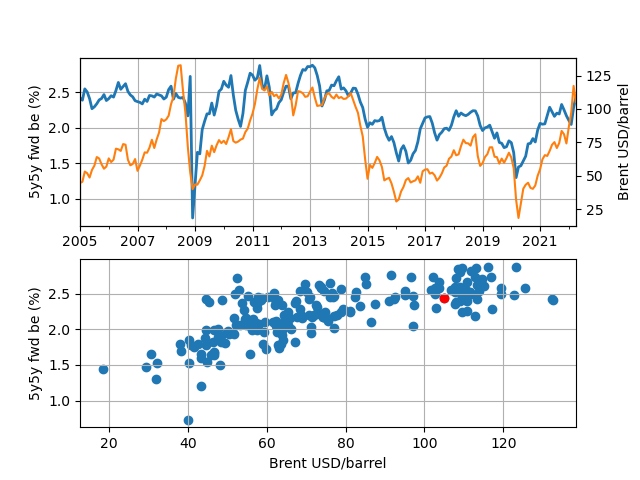

In [15]:
# let's also plot the history of the brent vs. the inflation rate and create a regression analysis with the latest value highlighted in a different colour
# the paper suggests to do this from 2005 (or after the great recession) onwards
START_YEAR = '2005'
fig, ax = plt.subplots(2,1)
ax1 = be5y5y.loc[START_YEAR:].plot(ax=ax[0], linewidth=2);
ax2 = brent.loc[START_YEAR:].plot(secondary_y=True, ax=ax[0]);
ax[0].grid(True);
ax1.set_ylabel('5y5y fwd be (%)');
ax2.set_ylabel('Brent USD/barrel');
plt.sca(ax[1])
tmp = brent.loc[START_YEAR:]
plt.scatter(tmp, be5y5y.loc[tmp.index]);
plt.scatter(tmp[-1], be5y5y.iloc[-1], color='r')
ax[1].grid(True);
ax[1].set_ylabel('5y5y fwd be (%)');
ax[1].set_xlabel('Brent USD/barrel');